In [1]:
# import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'

In [11]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV

import tensorflow as tf

import cv2

import Rakuten_preprocessing as rkt
from importlib import reload
reload(rkt)

from Rakuten_preprocessing import Rakuten_img_path

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

2024-03-04 12:18:13.801055: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 12:18:13.801384: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 12:18:13.805132: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 12:18:13.805312: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 12:18:13.805432: I external/local_xla/xla/stream_executor

## Loading the data

In [12]:
folder_path = '../data/clean/'
data_train = pd.read_csv(os.path.join(folder_path, 'df_train_index.csv'))
data_train['testset'] = False
data_test = pd.read_csv(os.path.join(folder_path, 'df_test_index.csv'))
data_test['testset'] = True
data = pd.concat([data_train, data_test], axis=0)

In [13]:
data.head()

,Unnamed: 0,designation,description,productid,imageid,language,designation_translated,description_translated,prdtypecode,prdtypedesignation,prdtypefull,prdtypeindex,testset
0,0,Porte Bébé Violet Et Rouge Trois-En-Un Mère Mu...,Porte bébé Violet et rouge Trois-en-un mère mu...,3050424970,1187504001,fr,Porte Bébé Violet Et Rouge Trois-En-Un Mère Mu...,Porte bébé Violet et rouge Trois-en-un mère mu...,1320,Puériculture,1320 - Puériculture,9,False
1,1,Jesus - Cahiers Du Libre Avenir,Prêtre autrement.,131641431,885888766,fr,Jesus - Cahiers Du Libre Avenir,Prêtre autrement.,10,Livres occasion,10 - Livres occasion,0,False
2,2,Chambre Paillasson En Forme De Coeur Tapis Flu...,Chambre Paillasson en forme de coeur Tapis Tap...,4197486437,1313030973,fr,Chambre Paillasson En Forme De Coeur Tapis Flu...,Chambre Paillasson en forme de coeur Tapis Tap...,1560,Mobilier,1560 - Mobilier,10,False
3,3,2pcs En Alliage D'aluminium Portail Du Carter ...,2pcs en alliage d'aluminium Portail du carter ...,3929174950,1265009801,fr,2pcs En Alliage D'aluminium Portail Du Carter ...,2pcs en alliage d'aluminium Portail du carter ...,1280,Jouets enfants,1280 - Jouets enfants,4,False
4,4,Harnais Chien Arnais Noir Anti Traction Gilet ...,La description: Fait de matériau souple doux ...,4183293159,1313455838,fr,Harnais Chien Arnais Noir Anti Traction Gilet ...,La description: Fait de matériau souple doux ...,2220,Animalerie,2220 - Animalerie,14,False


## Label encoding

In [6]:
from sklearn.preprocessing import LabelEncoder

target = data['prdtypedesignation']

#Encoding classes as integers
encoder = LabelEncoder()
y_class = encoder.fit_transform(target)

## Function to plot results

In [14]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_classification_results(y_true, y_pred, index=None):
    #Print evaluation metrics
    print(classification_report(y_true, y_pred))
    
    #Build confusion matrix
    conf_mat = pd.crosstab(y_true, y_pred, rownames=['Classes reelles'], colnames=['Classes predites'], normalize='columns')*100

    #in case labels are encoded, update with the original lables provided
    if index is not None:
        conf_mat.index = index
        conf_mat.columns = index
        
    #hierarchical clustering to find optimal order of labels
    Z = linkage(conf_mat, 'ward')
    order = leaves_list(Z)
    conf_mat = conf_mat.iloc[order, order]

    #plot confusion matrix as heatmap
    plt.figure(figsize=(15,12))
    sns.heatmap(conf_mat, annot=round(conf_mat,2), center=50, cmap=sns.color_palette('rocket',  as_cmap=True))
    plt.show()
    
    return plt

## Dataframe for Image Generator

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


#For windows
# img_folder = r"C:\Users\Julien Fournier\Documents\DST\RakutenProject\Data\images\image_train_resized"
#For wsl
img_folder = "/home/jul/DST/Rakuten/Data/images/image_train_resized"

img_paths = Rakuten_img_path(img_folder=img_folder,
                             imageid=data['imageid'], productid=data['productid'], suffix='_resized')

data_img = pd.DataFrame({'labels': data['prdtypeindex'], 'img_path': img_paths})

df_train, df_test = data_img[~data['testset']], data_img[data['testset']]

## Loading Vision Transformer

In [5]:
from transformers import TFViTModel, ViTForImageClassification, ViTImageProcessor

model_url = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTImageProcessor.from_pretrained(model_url)
vit_model = TFViTModel.from_pretrained(model_url, trainable=True)

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [10]:
from keras.preprocessing.image import ImageDataGenerator
import multiprocessing
from PIL import Image

img_size = (224, 224, 3)


#Data generator for the train and test sets
train_data_generator = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                                          horizontal_flip=True, fill_mode='constant', cval=255)

test_data_generator = ImageDataGenerator(fill_mode='constant', cval=255)

train_gen = train_data_generator.flow_from_dataframe(dataframe=df_train, x_col='img_path', y_col='labels',
                                                           class_mode='raw', shuffle=True, target_size=img_size[:2],
                                                           batch_size=64, use_multiprocessing=True, workers= 10)

test_gen = test_data_generator.flow_from_dataframe(dataframe=df_test, x_col='img_path', y_col='labels',
                                                           class_mode='raw', shuffle=False, target_size=img_size[:2],
                                                           batch_size=64, use_multiprocessing=True, workers= 10)


def preprocess_and_extract_features(generator):
    for batch in generator:
        images, labels = batch
        # Apply the ViT feature extractor to each batch of images
        images = np.array(images, dtype=np.uint8)
        images = feature_extractor(images, return_tensors='pt').pixel_values
        # images = np.transpose(images, (0, 2, 3, 1))
        yield images, labels

# Wrap the original generators
train_gen_preprocessed = preprocess_and_extract_features(train_gen)
test_gen_preprocessed = preprocess_and_extract_features(test_gen)

Found 67932 validated image filenames.
Found 16984 validated image filenames.


## Vision Transformer from HuggingFace

In [12]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from transformers import TFViTModel, ViTForImageClassification, ViTFeatureExtractor

num_class = len(np.unique(y_class))

inputs = Input(shape=(3, img_size[0], img_size[1]))

x = vit_model(inputs)[0][:, 0, :]

# x = transformer_layer[0][:, 0, :]

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_class, activation='softmax')(x)

# Construct the final model
model = Model(inputs=inputs, outputs=output)

lr = 5e-4
optimizer = Adam(learning_rate=lr)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 3, 224, 224)]        0         []                            
                                                                                                  
 tf.compat.v1.transpose_49   (None, 224, 224, 3)          0         ['input_2[0][0]']             
 (TFOpLambda)                                                                                     
                                                                                                  
 tf.compat.v1.shape_14 (TFO  (4,)                         0         ['input_2[0][0]']             
 pLambda)                                                                                         
                                                                                            

In [13]:
batch_size = 64
steps_per_epoch = len(df_train) // batch_size

history = model.fit(x=train_gen_preprocessed, validation_data=test_gen_preprocessed, steps_per_epoch=steps_per_epoch, epochs=10, verbose=True)

Epoch 1/10


2024-03-03 21:51:54.965819: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5e282d2a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-03 21:51:54.965861: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-03 21:51:54.965868: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-03 21:51:54.971716: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709499115.172000   11472 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1061/1061 [==============================] - ETA: 0s - loss: 1.9028 - accuracy: 0.4647

KeyboardInterrupt: 

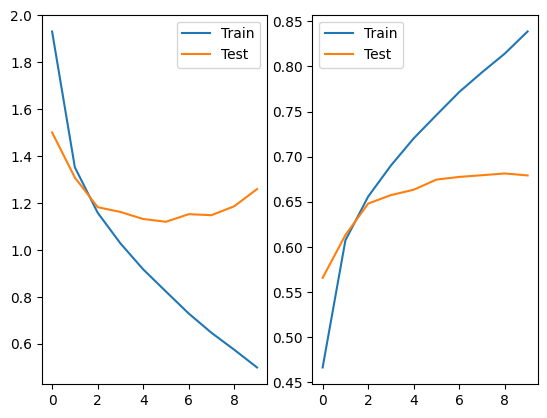

In [58]:
f, axs = plt.subplots(nrows=1, ncols=2)
axs[0].plot(history.history['loss'], label='Train')
axs[0].plot(history.history['val_loss'], label='Test')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='Train')
axs[1].plot(history.history['val_accuracy'], label='Test')
axs[1].legend()

plt.show()

In [59]:
test_pred = model.predict(x=test_generator)

266/266 [==============================] - 44s 160ms/step


              precision    recall  f1-score   support

           0       0.51      0.50      0.51       336
           1       0.59      0.50      0.54       165
           2       0.94      0.93      0.93       791
           3       0.69      0.76      0.73       161
           4       0.75      0.80      0.77       166
           5       0.51      0.35      0.41       153
           6       0.65      0.72      0.68       534
           7       0.67      0.79      0.73       998
           8       0.42      0.31      0.36       414
           9       0.72      0.80      0.76      1009
          10       0.59      0.74      0.65       502
          11       0.81      0.56      0.66       284
          12       0.79      0.34      0.47       174
          13       0.49      0.45      0.47       974
          14       0.86      0.85      0.85       861
          15       0.75      0.68      0.72       955
          16       0.87      0.33      0.48       552
          17       0.43    

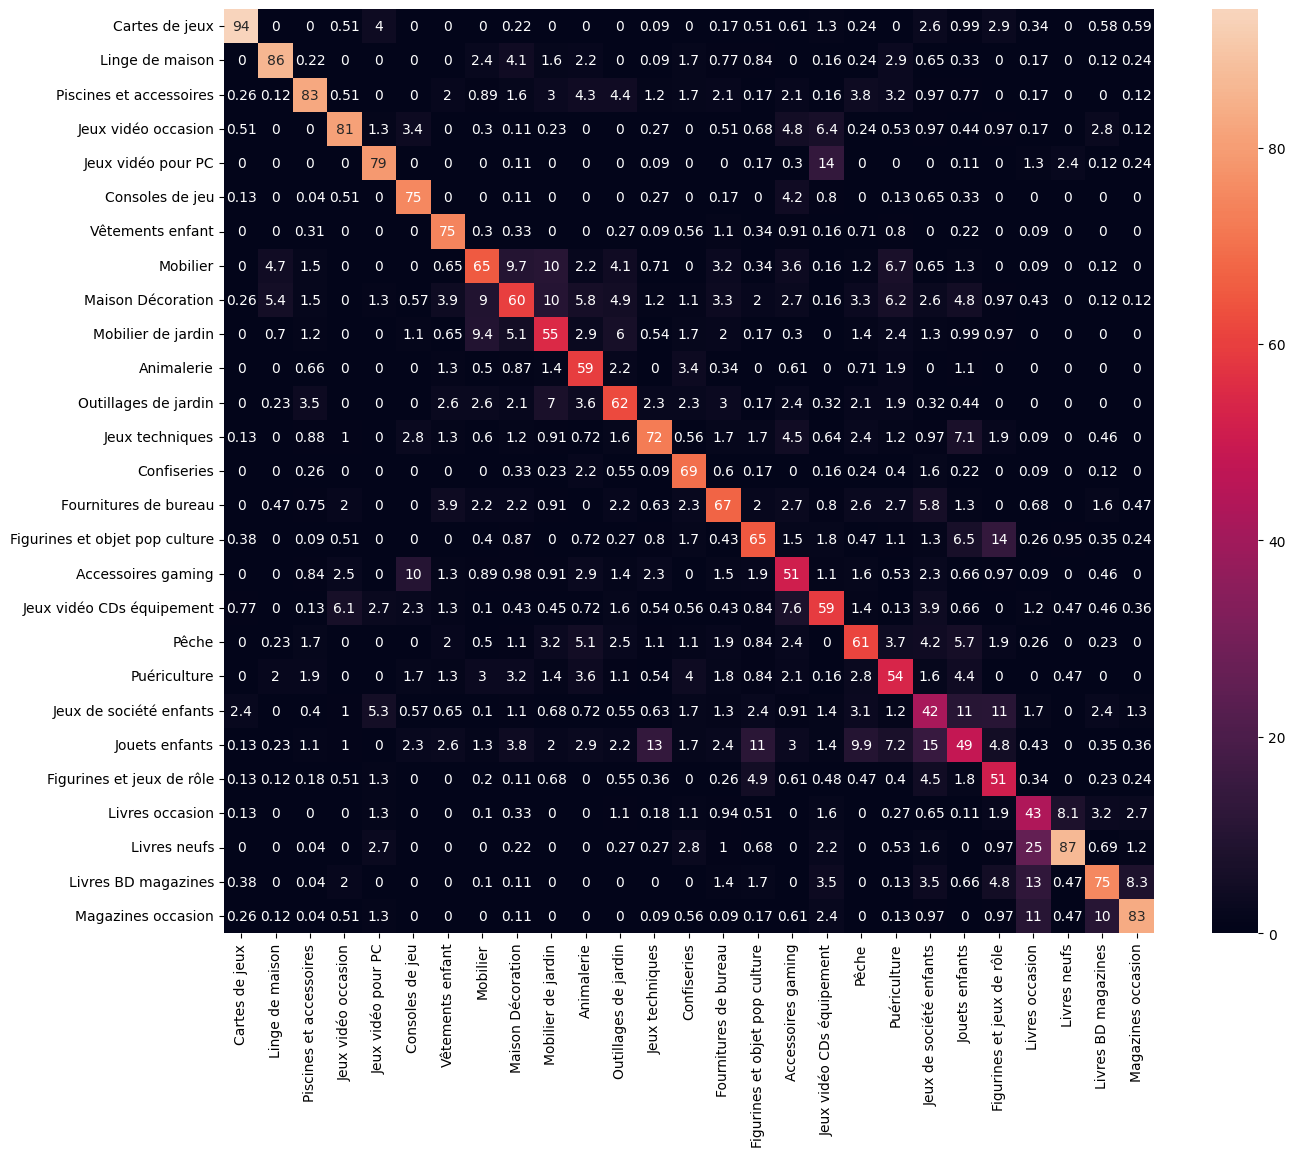

<module 'matplotlib.pyplot' from '/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [60]:
test_pred_class = np.argmax(test_pred, axis=1)
plot_classification_results(df_test['labels'], test_pred_class, index=encoder.classes_)

In [61]:
from sklearn.metrics import f1_score

f1_score(df_test['labels'], test_pred_class, average='weighted')

0.6741388991007558

## Vision transformer using vit-keras

In [16]:
from vit_keras import vit

img_size = (224, 224, 3)
vit_model = vit.vit_b16(image_size = img_size[0:2], activation = 'softmax',
                        pretrained = True, include_top = False, pretrained_top = False)

/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning:

Resizing position embeddings from 24, 24 to 14, 14



In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import multiprocessing

batch_size = 32

#Data generator for the train and test sets
train_data_generator = ImageDataGenerator(rescale = 1./255, samplewise_center = True, samplewise_std_normalization = True,
                                          rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                                          horizontal_flip=True, fill_mode='constant', cval=255)

test_data_generator = ImageDataGenerator(rescale = 1./255, samplewise_center = True, samplewise_std_normalization = True,
                                         fill_mode='constant', cval=255)

train_gen = train_data_generator.flow_from_dataframe(dataframe=df_train, x_col='img_path', y_col='labels',
                                                           class_mode='raw', shuffle=True, target_size=img_size[:2],
                                                           batch_size=batch_size, use_multiprocessing=True, workers= 10)

test_gen = test_data_generator.flow_from_dataframe(dataframe=df_test, x_col='img_path', y_col='labels',
                                                           class_mode='raw', shuffle=False, target_size=img_size[:2],
                                                           batch_size=batch_size, use_multiprocessing=True, workers= 10)

Found 67932 validated image filenames.
Found 16984 validated image filenames.


In [18]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from transformers import TFViTModel, ViTForImageClassification, ViTFeatureExtractor

num_class = len(np.unique(y_class))

vit_model = vit.vit_b16(image_size = img_size[0:2], activation = 'softmax',
                        pretrained = True, weights="imagenet21k",
                        include_top = False, pretrained_top = False)

model = Sequential(name = 'vision_transformer')
model.add(Input(shape=img_size))
model.add(vit_model)
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(num_class, activation = 'softmax'))

lr = 2e-5
optimizer = Adam(learning_rate=lr)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               86389248  
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 27)                3483      
                                                                 
Total params: 86491163 (329.94 MB)
Trainable params: 86491163 (329.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# import os
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [19]:
history = model.fit(x=train_gen, validation_data=test_gen, epochs=5)

Epoch 1/5


2024-03-05 16:34:42.471600: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-05 16:34:45.594570: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-05 16:34:46.328207: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-05 16:34:48.266050: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6d5c685ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-05 16:34:48.266101: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-05 16:34:48.266109: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-05 16:34:48.272131: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disa

2123/2123 [==============================] - 1317s 597ms/step - loss: 1.8120 - accuracy: 0.4884 - val_loss: 1.3697 - val_accuracy: 0.5980
Epoch 2/5
2123/2123 [==============================] - 1268s 597ms/step - loss: 1.2712 - accuracy: 0.6274 - val_loss: 1.1974 - val_accuracy: 0.6436
Epoch 3/5
2123/2123 [==============================] - 1268s 597ms/step - loss: 1.0715 - accuracy: 0.6831 - val_loss: 1.1484 - val_accuracy: 0.6563
Epoch 4/5
2123/2123 [==============================] - 1277s 601ms/step - loss: 0.9232 - accuracy: 0.7232 - val_loss: 1.0899 - val_accuracy: 0.6750
Epoch 5/5
2123/2123 [==============================] - 1263s 595ms/step - loss: 0.7916 - accuracy: 0.7597 - val_loss: 1.1014 - val_accuracy: 0.6763


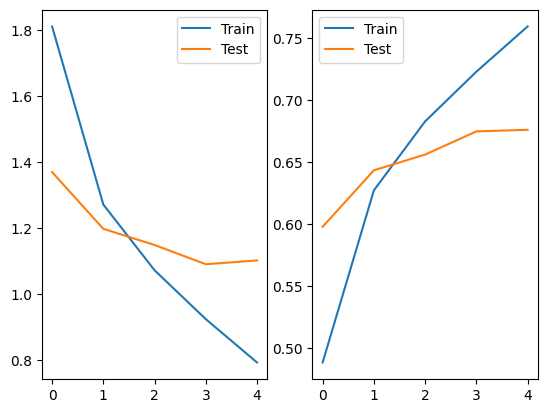

In [20]:
f, axs = plt.subplots(nrows=1, ncols=2)
axs[0].plot(history.history['loss'], label='Train')
axs[0].plot(history.history['val_loss'], label='Test')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='Train')
axs[1].plot(history.history['val_accuracy'], label='Test')
axs[1].legend()

plt.show()

In [21]:
test_pred = model.predict(x=test_gen)
test_pred_class = np.argmax(test_pred, axis=1)

531/531 [==============================] - 134s 246ms/step


In [22]:
from sklearn.metrics import f1_score

f1_score(df_test['labels'], test_pred_class, average='weighted')

0.6716440180323435

In [23]:
model.save(filepath='../models/trained_models/ViT_b16')
# model2 = tf.keras.models.load_model(filepath='../models/ViT_b16.tf')

INFO:tensorflow:Assets written to: ../models/trained_models/ViT_b16/assets


INFO:tensorflow:Assets written to: ../models/trained_models/ViT_b16/assets


              precision    recall  f1-score   support

           0       0.58      0.56      0.57       623
           1       0.79      0.57      0.66       534
           2       0.92      0.95      0.94       791
           3       0.60      0.37      0.46       153
           4       0.47      0.43      0.45       974
           5       0.43      0.31      0.36       414
           6       0.67      0.81      0.73      1009
           7       0.74      0.70      0.72       161
           8       0.52      0.49      0.50       498
           9       0.58      0.57      0.58       648
          10       0.64      0.61      0.63      1015
          11       0.80      0.85      0.83       861
          12       0.81      0.70      0.75       161
          13       0.49      0.64      0.55       999
          14       0.62      0.40      0.49       165
          15       0.70      0.88      0.78       952
          16       0.75      0.68      0.71       955
          17       0.76    

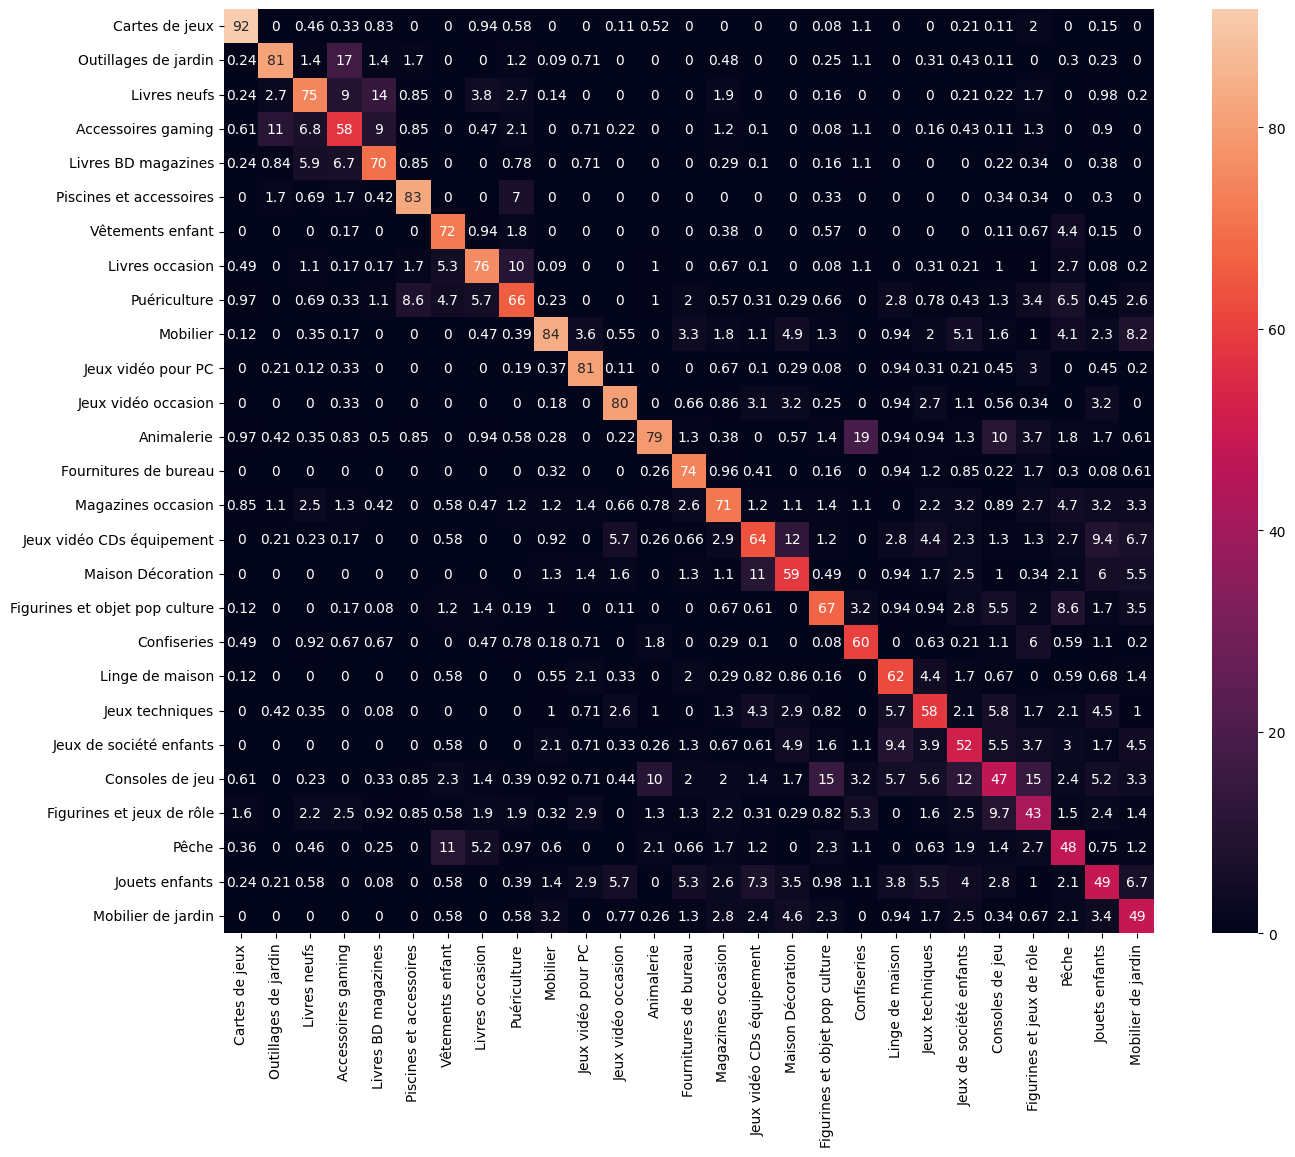

<module 'matplotlib.pyplot' from '/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [24]:
plot_classification_results(df_test['labels'], test_pred_class, index=encoder.classes_)